# Trabajo Práctico N° 1: Reducción de Dimensionalidad y Clustering
## Minería de Datos, TUIA

**Integrantes:**
* Armas, Alejandro
* Ferreira Da Camara, Facundo
* Soda, Gabriel

**24/10/2025**

In [253]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import plotly.express as px
from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import Isomap, TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples, pairwise_distances
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import cdist
import warnings
warnings.filterwarnings('ignore')

## 1. Carga, análisis exploratorio y Preprocesamiento de Datos

Carga del dataset, limpieza (nulos, duplicados), codificar variables categóricas y estandarización las características.

In [254]:
df = pd.read_csv('SmartFarmingCropYield.csv')
df.head()

tipoCultivo   humedadSuelo(%)   pHSuelo   temperatura(°C)  \
0       Trigo             35.95      5.99             17.79   
1        Soja             19.74      7.24             30.18   
2       Trigo             29.32      7.16             27.37   
3        Maiz             17.33      6.03             33.73   
4        Soja             36.28      7.04             21.80   

    precipitacion(mm)   humedad(%)   horasLuzSolar  tipoRiego  \
0               75.62        77.03            7.27        NaN   
1               89.91        61.13            5.67   Aspersor   
2              265.43        68.87            8.23      Goteo   
3              212.01        70.46            5.03   Aspersor   
4              123.38        47.91            4.02     Manual   

   tipoFertilizante   mlPesticida   diasTotales   rendimientoKg_hectarea  \
0          Organico          6.34           122                  4408.07   
1        Inorganico          9.60           112                  5389.98   
2             Mixto         15.26           144                  2931.16   
3          Organico         25.80           134                  4227.80   
4             Mixto         39.29           145                  4501.20   

    indiceNDVI  estadoEnfermedadesCultivo  
0         0.63                       Leve  
1         0.58                        NaN  
2         0.80                       Leve  
3         0.44                        NaN  
4         0.76                        NaN

In [255]:
# Revisa si hay filas duplicadas
print(f"Filas duplicadas: {df.duplicated().sum()}") # 0 filas duplicadas

# Información inicial
print("\nColumnas del DataFrame:")
for col in df.columns:
    print(f"-{col}-")

Filas duplicadas: 0

Columnas del DataFrame:
-tipoCultivo-
- humedadSuelo(%)-
- pHSuelo-
- temperatura(°C)-
- precipitacion(mm)-
- humedad(%)-
- horasLuzSolar-
- tipoRiego-
- tipoFertilizante-
- mlPesticida-
- diasTotales-
- rendimientoKg_hectarea-
- indiceNDVI-
- estadoEnfermedadesCultivo-


In [256]:
# Elimina espacios en blanco en los nombres de las columnas
df.columns = df.columns.str.strip()

In [257]:
# Identificamos las columnas numéricas y categóricas
variables_numericas = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
variables_categoricas = df.select_dtypes(include=['object']).columns.tolist()

# Revisa los valores únicos en las columnas categóricas
print(f"\nTipoRiego: {df['tipoRiego'].unique()}")
print(f"tipoFertilizante: {df['tipoFertilizante'].unique()}")
print(f"estadoEnfermedadesCultivo{df['estadoEnfermedadesCultivo'].unique()}")
print(f"tipoCultivo (target): {df['tipoCultivo'].unique()}")


TipoRiego: [nan 'Aspersor' 'Goteo' 'Manual']
tipoFertilizante: ['Organico' 'Inorganico' 'Mixto']
estadoEnfermedadesCultivo['Leve' nan 'Moderate' 'Severo']
tipoCultivo (target): ['Trigo' 'Soja' 'Maiz']


In [258]:
df.describe(include='number', percentiles=[0.01, 0.1,0.25, 0.5, 0.75, 0.9, 0.99])

humedadSuelo(%)     pHSuelo  temperatura(°C)  precipitacion(mm)  \
count       311.000000  311.000000       311.000000         311.000000   
mean         26.643280    6.526109        24.702508         180.920547   
std          10.019434    0.594342         5.156819          74.046772   
min          10.220000    5.510000        15.000000          50.170000   
1%           10.283000    5.521000        15.237000          57.318000   
10%          13.570000    5.670000        17.740000          75.670000   
25%          17.855000    6.030000        20.305000         115.250000   
50%          25.820000    6.520000        24.780000         192.360000   
75%          35.540000    7.050000        28.790000         244.995000   
90%          40.690000    7.350000        32.030000         279.060000   
99%          44.157000    7.479000        34.330000         297.536000   
max          44.980000    7.500000        34.840000         298.960000   

       humedad(%)  horasLuzSolar  mlPesticida  diasTotales  \
count  311.000000     311.000000   311.000000   311.000000   
mean    65.980418       6.949550    25.930707   119.768489   
std     14.144594       1.740517    13.413323    16.519132   
min     40.230000       4.010000     5.050000    90.000000   
1%      40.654000       4.021000     5.440000    91.000000   
10%     46.240000       4.580000     8.560000    97.000000   
25%     53.405000       5.470000    14.055000   106.000000   
50%     67.000000       6.870000    25.220000   118.000000   
75%     78.110000       8.400000    38.020000   134.000000   
90%     84.760000       9.450000    44.710000   142.000000   
99%     89.276000       9.947000    49.423000   149.900000   
max     89.840000      10.000000    49.940000   150.000000   

       rendimientoKg_hectarea  indiceNDVI  
count              311.000000  311.000000  
mean              4105.907331    0.604598  
std               1169.068792    0.177522  
min               2023.560000    0.300000  
1%                2049.215000    0.300000  
10%               2454.600000    0.350000  
25%               3135.915000    0.450000  
50%               4146.290000    0.620000  
75%               5186.975000    0.755000  
90%               5632.100000    0.850000  
99%               5953.960000    0.890000  
max               5998.290000    0.900000

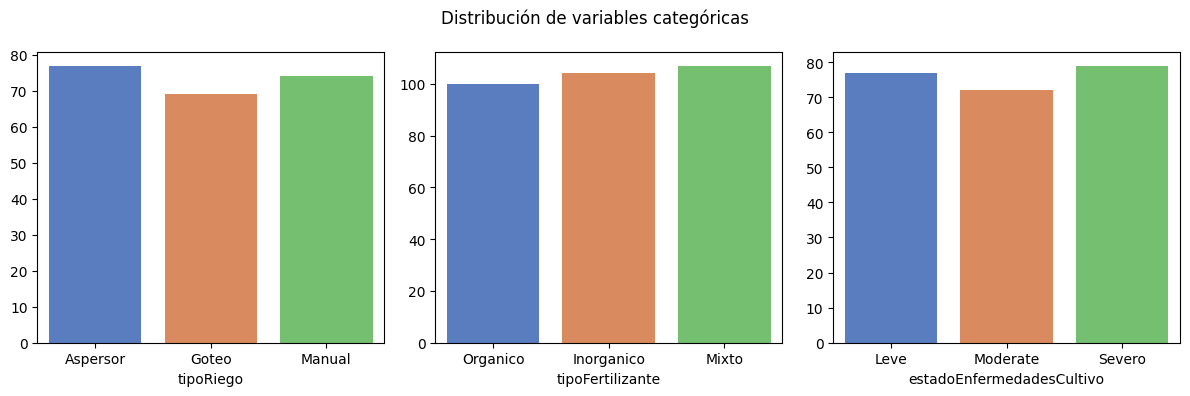

In [259]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

sns.countplot(data=df, x="tipoRiego", palette="muted", hue="tipoRiego", ax=axes[0], legend=False)
sns.countplot(data=df, x="tipoFertilizante", palette="muted", hue="tipoFertilizante", ax=axes[1], legend=False)
sns.countplot(data=df, x="estadoEnfermedadesCultivo", palette="muted", hue="estadoEnfermedadesCultivo", ax=axes[2], legend=False)

plt.suptitle("Distribución de variables categóricas")

for ax in axes.flat:
    ax.set_ylabel('')
plt.tight_layout()
plt.show()

**Tipo de Riego:**
Los tipos de riego Aspersor y Manual tienen frecuencia de uso similar y mayor a la de Goteo.

**Tipo de Fertilizante:**
El fertilizante Inorganico tiene una frecuencia levemente mayor a Mixto e Inorgánico.

**Estado de enfermedad:**
El estado de enfermedad 'Severo' es el mas frecuente seguido de 'Leve' y luego 'Moderado'.

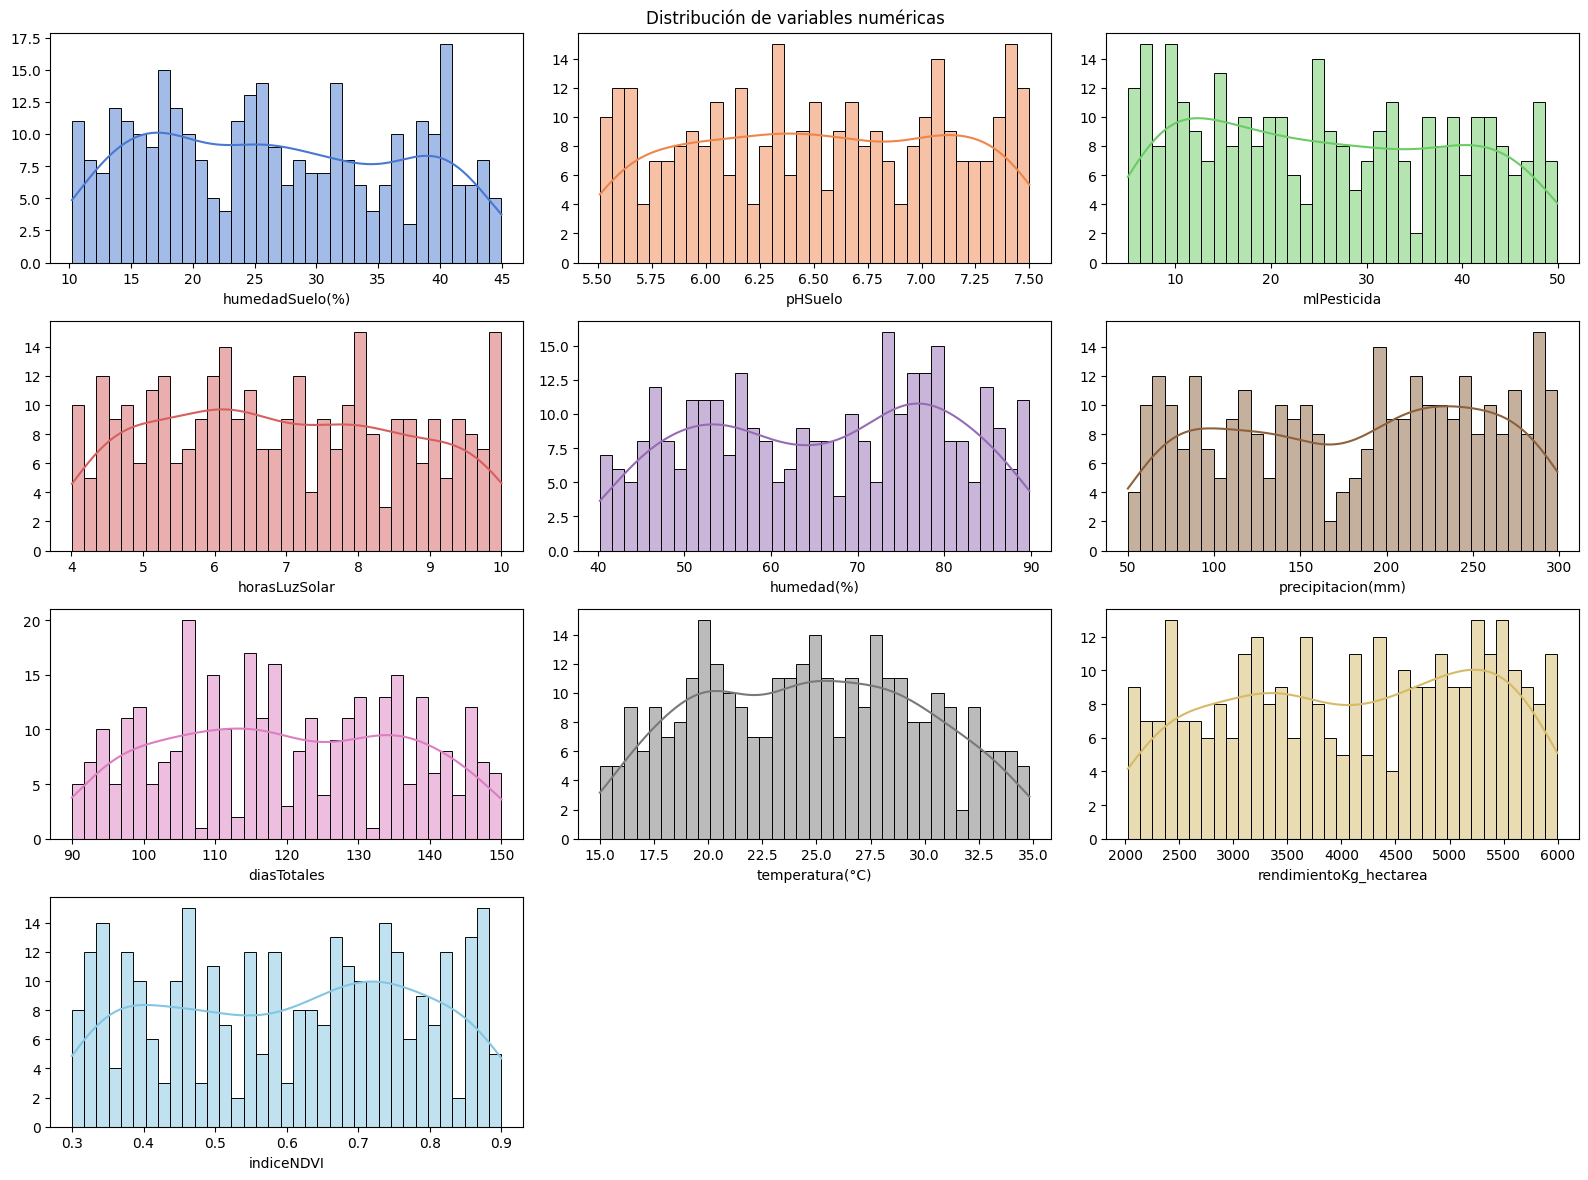

In [260]:
fig, axes = plt.subplots(4, 3, figsize=(16, 12))

sns.histplot(data=df, x="humedadSuelo(%)",bins=35, color=sns.color_palette("muted")[0], ax=axes[0,0], kde=True)
sns.histplot(data=df, x="pHSuelo",bins=35, color=sns.color_palette("muted")[1], ax=axes[0,1], kde=True)
sns.histplot(data=df, x="mlPesticida",bins=35, color=sns.color_palette("muted")[2], ax=axes[0,2], kde=True)
sns.histplot(data=df, x="horasLuzSolar",bins=35, color=sns.color_palette("muted")[3], ax=axes[1,0], kde=True)
sns.histplot(data=df, x="humedad(%)",bins=35, color=sns.color_palette("muted")[4], ax=axes[1,1], kde=True)
sns.histplot(data=df, x="precipitacion(mm)",bins=35, color=sns.color_palette("muted")[5], ax=axes[1,2], kde=True)
sns.histplot(data=df, x="diasTotales",bins=35, color=sns.color_palette("muted")[6], ax=axes[2,0], kde=True)
sns.histplot(data=df, x="temperatura(°C)",bins=35, color=sns.color_palette("muted")[7], ax=axes[2,1], kde=True)
sns.histplot(data=df, x="rendimientoKg_hectarea",bins=35, color=sns.color_palette("muted")[8], ax=axes[2,2], kde=True)
sns.histplot(data=df, x="indiceNDVI", bins=35, color=sns.color_palette("muted")[9], ax=axes[3,0], kde=True)

plt.suptitle("Distribución de variables numéricas")

fig.delaxes(axes[3,1])
fig.delaxes(axes[3,2])
for ax in axes.flat:
    ax.set_ylabel('')

plt.tight_layout()
plt.show()

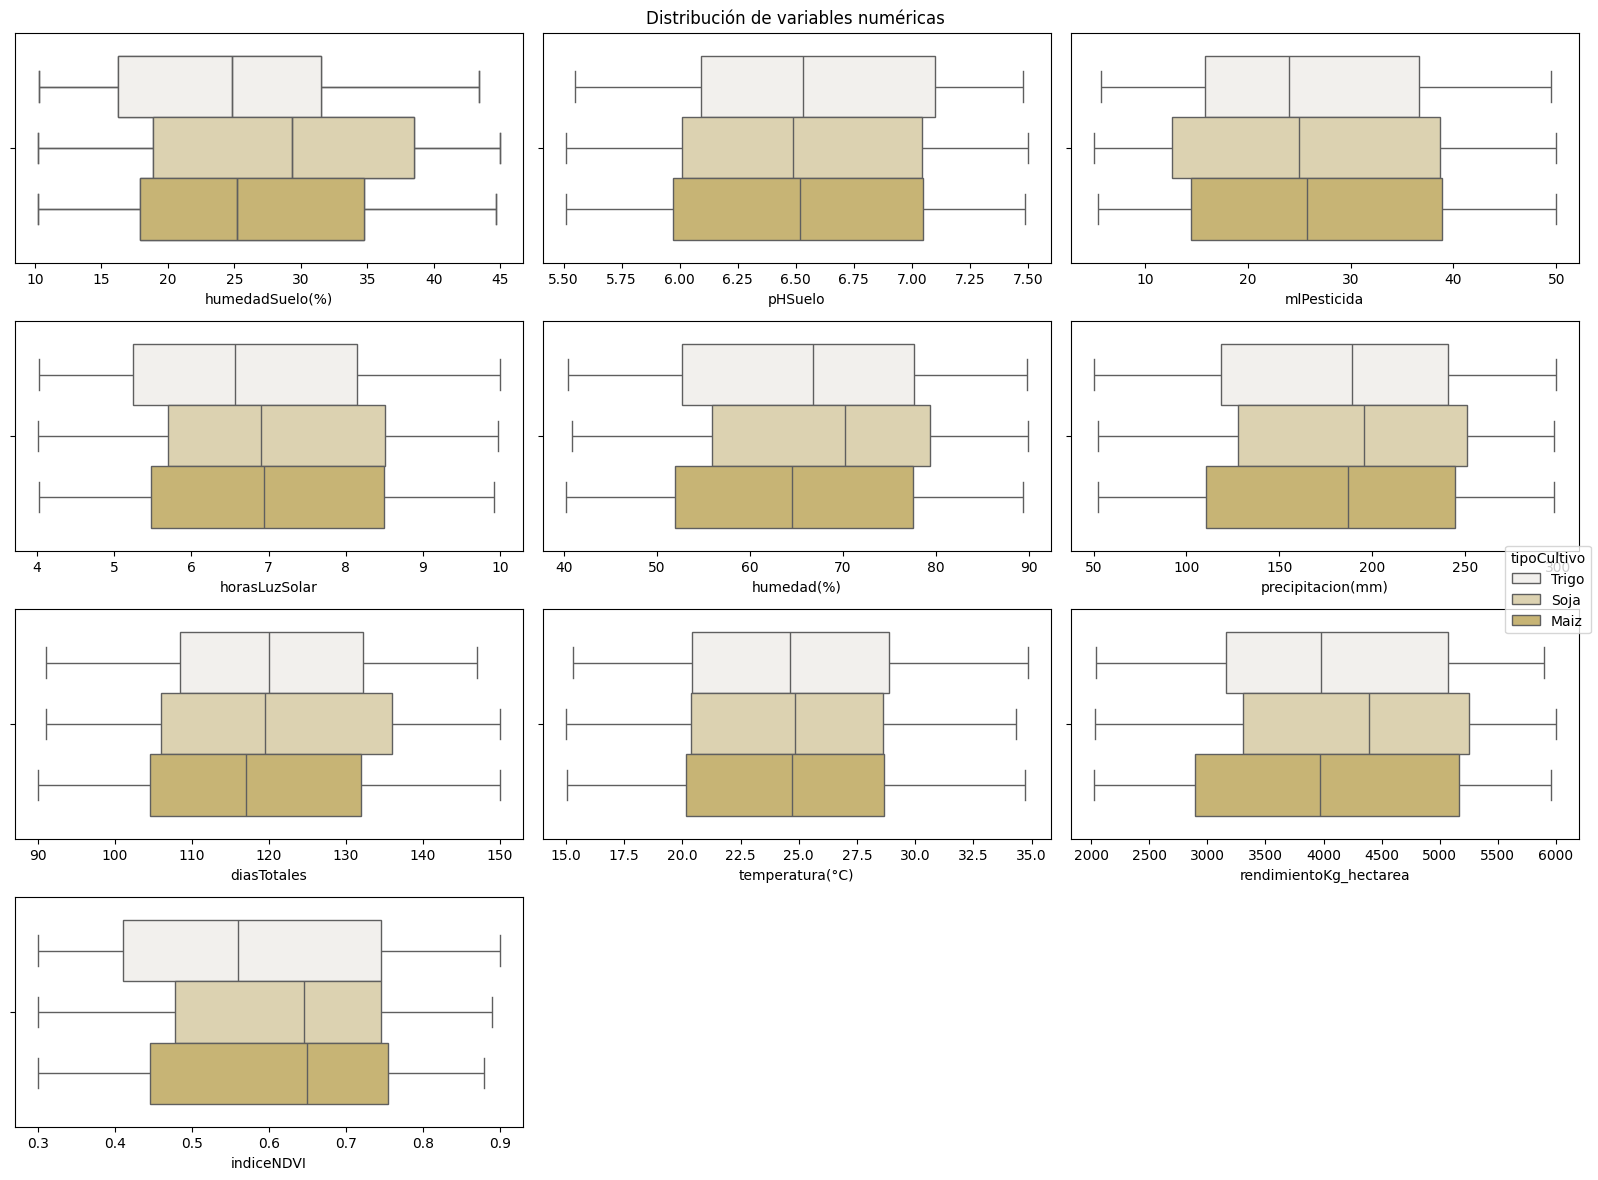

In [261]:
fig, axes = plt.subplots(4, 3, figsize=(16, 12))

sns.boxplot(data=df, x="humedadSuelo(%)", palette='light:#d5bb67',
            hue="tipoCultivo", ax=axes[0,0])
handles, labels = axes[0,0].get_legend_handles_labels()
axes[0,0].legend_.remove()

sns.boxplot(data=df, x="humedadSuelo(%)", palette='light:#d5bb67', hue="tipoCultivo", ax=axes[0,0], legend=False)
sns.boxplot(data=df, x="pHSuelo", palette='light:#d5bb67', hue="tipoCultivo", ax=axes[0,1], legend=False)
sns.boxplot(data=df, x="mlPesticida", palette='light:#d5bb67', hue="tipoCultivo", ax=axes[0,2], legend=False)
sns.boxplot(data=df, x="horasLuzSolar", palette='light:#d5bb67', hue="tipoCultivo", ax=axes[1,0], legend=False)
sns.boxplot(data=df, x="humedad(%)", palette='light:#d5bb67', hue="tipoCultivo", ax=axes[1,1], legend=False)
sns.boxplot(data=df, x="precipitacion(mm)", palette='light:#d5bb67', hue="tipoCultivo", ax=axes[1,2], legend=False)
sns.boxplot(data=df, x="diasTotales", palette='light:#d5bb67', hue="tipoCultivo", ax=axes[2,0], legend=False)
sns.boxplot(data=df, x="temperatura(°C)", palette='light:#d5bb67', hue="tipoCultivo", ax=axes[2,1], legend=False)
sns.boxplot(data=df, x="rendimientoKg_hectarea", palette='light:#d5bb67', hue="tipoCultivo", ax=axes[2,2], legend=False)
sns.boxplot(data=df, x="indiceNDVI", palette='light:#d5bb67', hue="tipoCultivo", ax=axes[3,0], legend=False)

fig.delaxes(axes[3,1])
fig.delaxes(axes[3,2])

plt.suptitle("Distribución de variables numéricas")
fig.legend(handles, labels, title='tipoCultivo',loc='center right', )
for ax in axes.flat:
    ax.set_ylabel('')

plt.tight_layout()
plt.show()

De los gráficos de boxplots no se observan outliers en ninguna variable.
Notamos importante solapamiento en las distribuciones de las variables numéricas entre los distintos tipos de cultivo.
Posiblemente esto haga que la tarea de clustering sea más compleja.

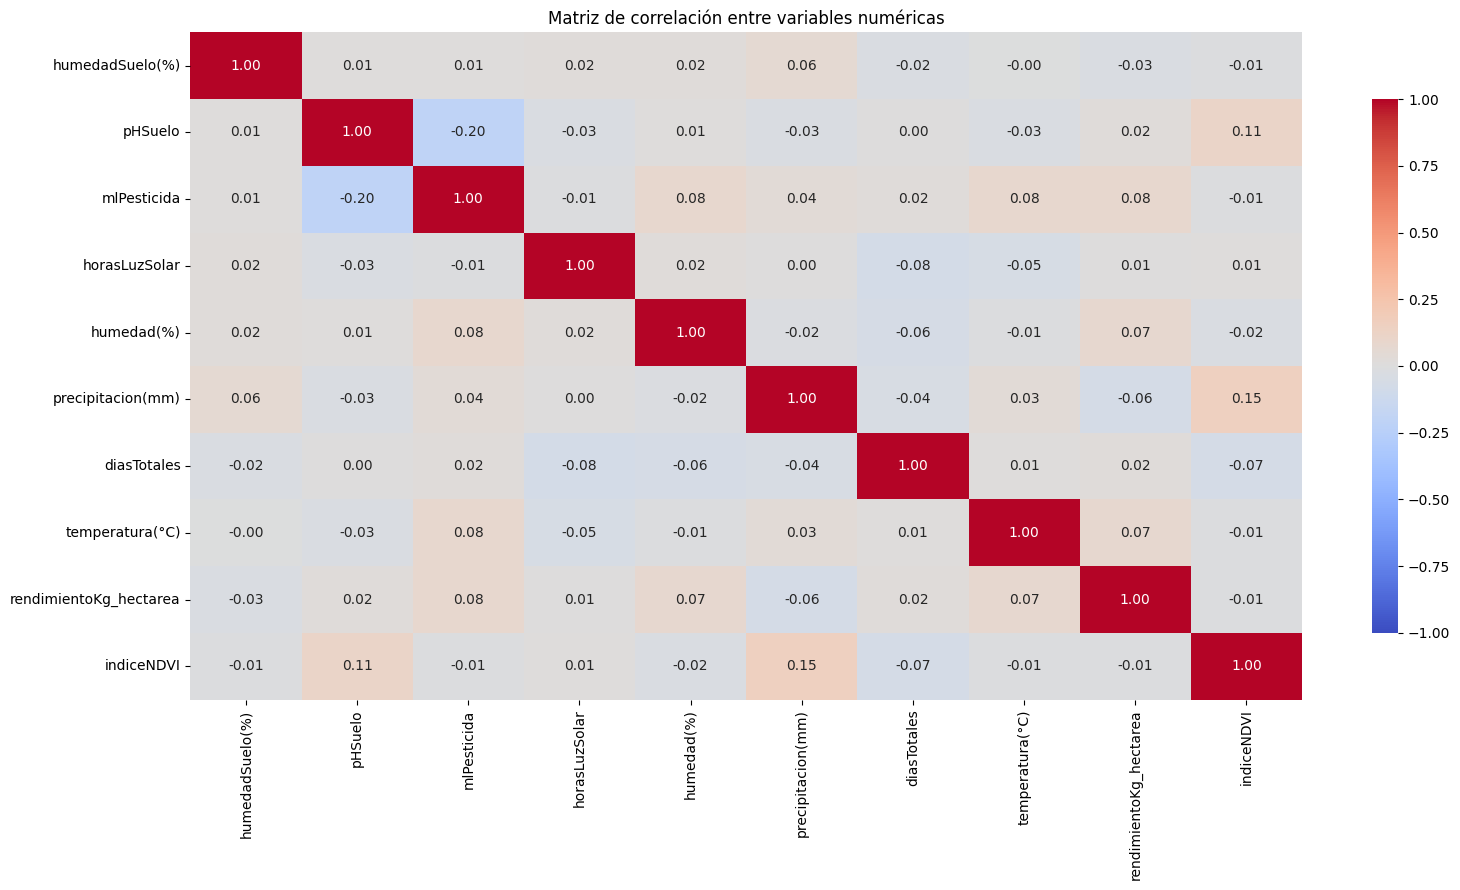

In [262]:
# Correlación entre variables numéricas
variables_numericas = ["humedadSuelo(%)", "pHSuelo", "mlPesticida", "horasLuzSolar", "humedad(%)", "precipitacion(mm)", "diasTotales", "temperatura(°C)", "rendimientoKg_hectarea", "indiceNDVI"]

plt.figure(figsize=(16, 9))

sns.heatmap(df[variables_numericas].corr(), annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={"shrink": .8}, vmin=-1, vmax=1)

plt.title("Matriz de correlación entre variables numéricas")

plt.tight_layout()
plt.show()

No se observan correlaciones muy fuertes entre las variables numéricas.

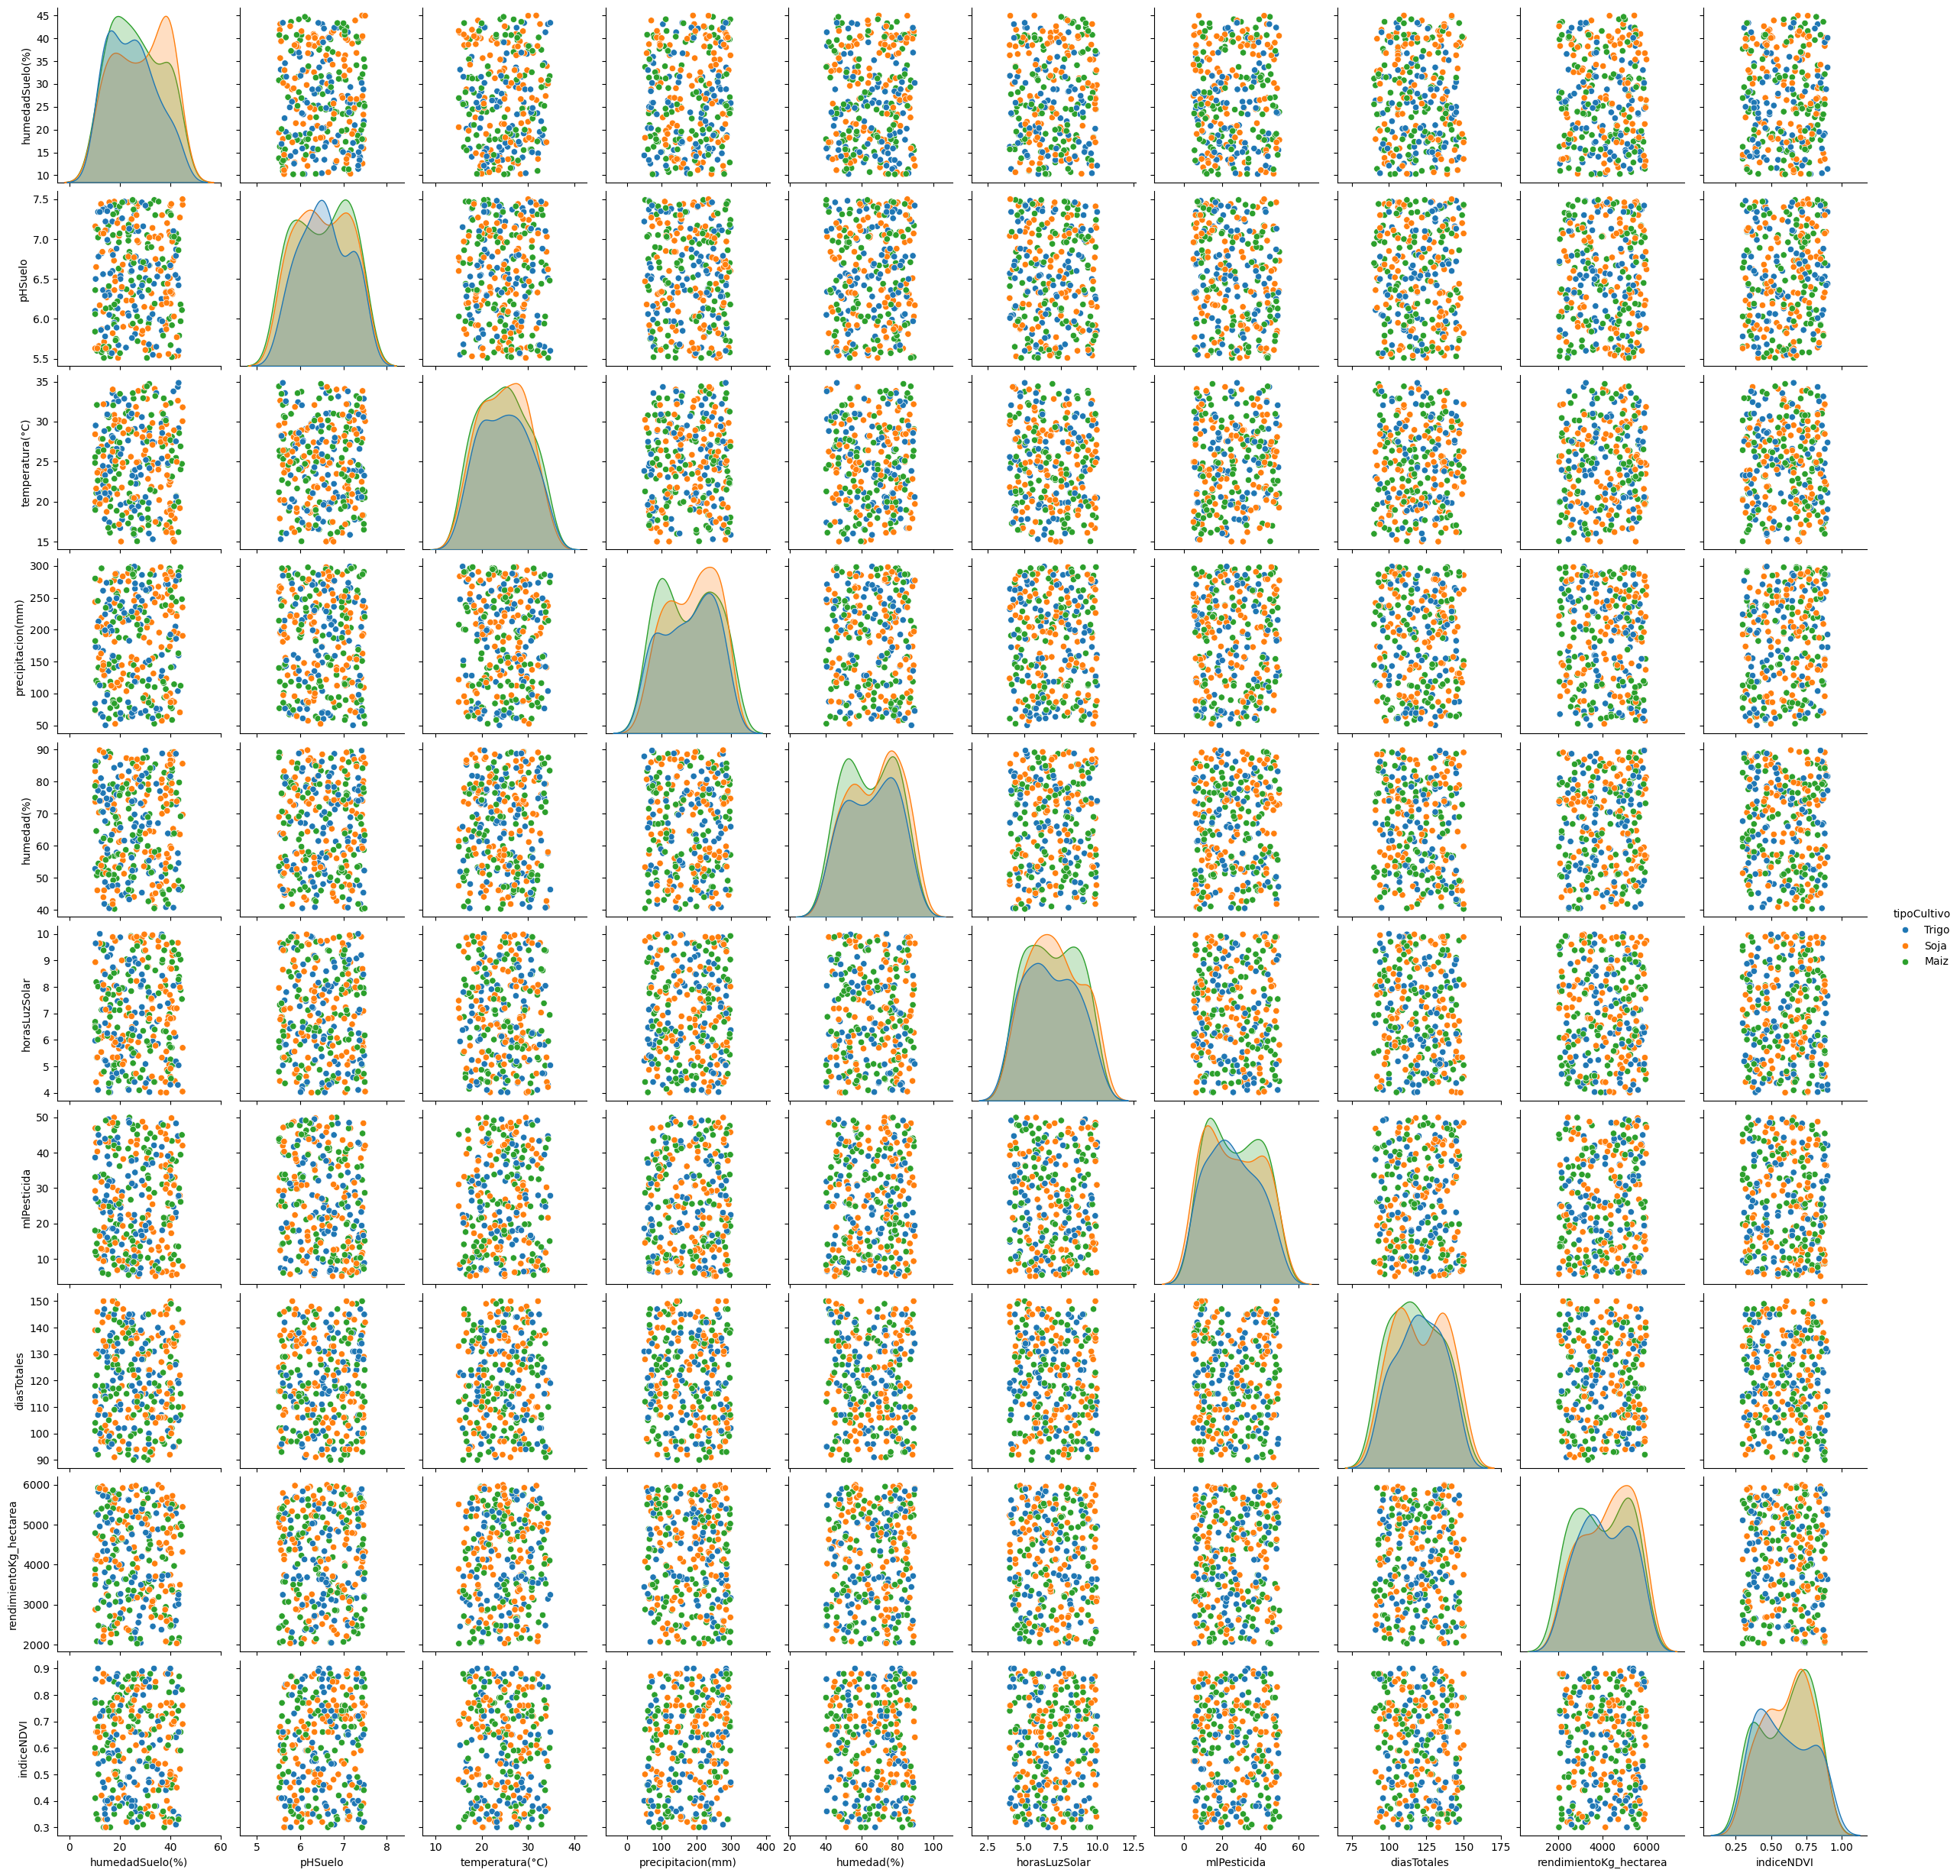

In [263]:
sns.pairplot(df,hue='tipoCultivo')
plt.show()

De los gráficos de pairplot no se observan relaciones lineales claras entre las variables numéricas, lo que 
coincide con la baja correlación observada en la matriz de correlación.
















### 1.1. Análisis, Limpieza y manejo de Valores Faltantes 

In [264]:
faltantes_df = pd.DataFrame({
    'NaN': df.isna().sum(),
    '%': (df.isna().sum() / len(df) * 100).round(2)
}).sort_values('NaN', ascending=False)
faltantes_df

NaN      %
tipoRiego                   91  29.26
estadoEnfermedadesCultivo   83  26.69
pHSuelo                      0   0.00
temperatura(°C)              0   0.00
tipoCultivo                  0   0.00
humedadSuelo(%)              0   0.00
humedad(%)                   0   0.00
precipitacion(mm)            0   0.00
tipoFertilizante             0   0.00
horasLuzSolar                0   0.00
mlPesticida                  0   0.00
diasTotales                  0   0.00
rendimientoKg_hectarea       0   0.00
indiceNDVI                   0   0.00

### Criterio para manejo de nulos:
Aunque la cantidad de datos faltantes es muy grande respecto al total de datos (~29.4% por columna), imputar con la moda implicaría un gran cambio en la distribución original del conjunto de datos. Además podría generar un sesgo a la hora de realizar la clusterización.
Por tal motivo, decidimos eliminar las observaciones con datos faltantes.

In [265]:
# Overlap de NaN
nan_overlap = df[df['tipoRiego'].isna() & df['estadoEnfermedadesCultivo'].isna()].shape[0]
print(f"Filas con NaN en ambas columnas: {nan_overlap}")

Filas con NaN en ambas columnas: 26


In [266]:
# Eliminamos las filas con faltantes
df_cleaned = df.dropna().reset_index(drop=True)
print(f"Filas después de eliminar NaN: {df_cleaned.shape[0]}")

Filas después de eliminar NaN: 163


In [267]:
df = df_cleaned

In [268]:
# Separamos la variable objetivo (y) de las predictoras (X)
y = df['tipoCultivo']
X = df.drop('tipoCultivo', axis=1)

# Identificamos las columnas numéricas y categóricas
variables_numericas = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
variables_categoricas = X.select_dtypes(include=['object']).columns.tolist()

print(f"Variables numéricas: {variables_numericas}")
print(f"Variables categóricas: {variables_categoricas}")

# One-Hot Encoding solo para variables categóricas
X_encoded = pd.get_dummies(X, columns=variables_categoricas)#, drop_first=True)

print(f"\nDimensiones de X después de get_dummies: {X_encoded.shape}")
print("Columnas de X:", X_encoded.columns.tolist())

Variables numéricas: ['humedadSuelo(%)', 'pHSuelo', 'temperatura(°C)', 'precipitacion(mm)', 'humedad(%)', 'horasLuzSolar', 'mlPesticida', 'diasTotales', 'rendimientoKg_hectarea', 'indiceNDVI']
Variables categóricas: ['tipoRiego', 'tipoFertilizante', 'estadoEnfermedadesCultivo']

Dimensiones de X después de get_dummies: (163, 19)
Columnas de X: ['humedadSuelo(%)', 'pHSuelo', 'temperatura(°C)', 'precipitacion(mm)', 'humedad(%)', 'horasLuzSolar', 'mlPesticida', 'diasTotales', 'rendimientoKg_hectarea', 'indiceNDVI', 'tipoRiego_Aspersor', 'tipoRiego_Goteo', 'tipoRiego_Manual', 'tipoFertilizante_Inorganico', 'tipoFertilizante_Mixto', 'tipoFertilizante_Organico', 'estadoEnfermedadesCultivo_Leve', 'estadoEnfermedadesCultivo_Moderate', 'estadoEnfermedadesCultivo_Severo']


In [269]:
# Estandarización solo de las características numéricas
scaler = StandardScaler()
X_std = X_encoded.copy()

# Escalamos solo las columnas numéricas originales
X_std[variables_numericas] = scaler.fit_transform(X_encoded[variables_numericas])

print(f"\nDimensiones finales: {X_std.shape}")
print("\nPrimeras filas de X_std:")
X_std.head()


Dimensiones finales: (163, 19)

Primeras filas de X_std:


humedadSuelo(%)   pHSuelo  temperatura(°C)  precipitacion(mm)  humedad(%)  \
0         0.394017  1.040927         0.468253           1.084461    0.129232   
1         0.173440 -1.323141        -0.511037           1.501523    0.951804   
2         1.508827 -0.288861        -1.089796          -0.003546    0.676418   
3        -1.188775 -0.272444        -0.279151          -0.247304    0.672833   
4        -1.247397 -1.076884         0.378181           0.455088   -1.097812   

   horasLuzSolar  mlPesticida  diasTotales  rendimientoKg_hectarea  \
0       0.715899    -0.807933     1.414415               -1.060408   
1      -0.874106     1.589491     0.091070                0.961703   
2      -1.005182     1.750307    -0.081540                1.251525   
3       0.607619    -0.225437     1.471952               -1.488661   
4      -1.284430     0.414123    -0.196613                0.411652   

   indiceNDVI  tipoRiego_Aspersor  tipoRiego_Goteo  tipoRiego_Manual  \
0    1.132157               False             True             False   
1    0.569187                True            False             False   
2   -0.556753               False            False              True   
3   -0.275268               False             True             False   
4   -1.007130                True            False             False   

   tipoFertilizante_Inorganico  tipoFertilizante_Mixto  \
0                        False                    True   
1                        False                    True   
2                         True                   False   
3                        False                   False   
4                        False                    True   

   tipoFertilizante_Organico  estadoEnfermedadesCultivo_Leve  \
0                      False                            True   
1                      False                            True   
2                      False                            True   
3                       True                           False   
4                      False                           False   

   estadoEnfermedadesCultivo_Moderate  estadoEnfermedadesCultivo_Severo  
0                               False                             False  
1                               False                             False  
2                               False                             False  
3                                True                             False  
4                                True                             False

## 2. Análisis de Componentes Principales (PCA)

In [270]:
# Obtener todas las componentes principales
pca = PCA(n_components=X_std.shape[1]).set_output(transform="pandas")
pca_df = pca.fit_transform(X_std)
pca_df['target'] = y

In [271]:
# dataframe de componentes
pca_df

pca0      pca1      pca2      pca3      pca4      pca5      pca6  \
0   -0.849965  1.368536 -0.273208 -1.248903  1.359835  0.017182  0.948651   
1    1.664735  0.516465  1.665884 -0.064397  0.040914  0.059638  0.879285   
2    1.749869 -0.206123  0.719581  1.088812  0.835471  1.383753 -0.599157   
3   -0.851193 -1.257065  0.045696 -0.931529 -0.071019  0.424401  1.739916   
4    1.178115 -0.870735 -0.694668 -0.125358 -1.328176 -1.401599  0.273295   
..        ...       ...       ...       ...       ...       ...       ...   
158  1.276831 -0.320669 -0.250981  2.585499 -0.377352  0.691554  0.451857   
159  0.083068 -2.227520  1.275136 -1.964893 -0.045333  1.360628 -1.309944   
160 -0.093648 -1.886675 -0.261637 -1.105843  0.179190  0.605484 -0.803279   
161 -0.204721  2.527152  1.651317  0.397888  0.173620  0.836866 -0.297245   
162  0.213998 -0.026285  1.915350 -2.149780  1.528720  1.634933  0.114083   

         pca7      pca8      pca9     pca10     pca11     pca12     pca13  \
0    0.730067 -0.245499  0.677697 -0.096202  1.330726  0.043929 -0.250182   
1   -1.158189  0.941761 -1.008688 -0.610513  0.374934  0.662209 -0.260274   
2   -1.439681 -0.046835 -0.729581 -1.099814 -0.073611 -0.312660 -0.289014   
3    0.575899  0.027780  0.642882  0.917700  0.269500 -0.939033 -0.170278   
4   -0.989042  0.887110 -0.084045  0.099713 -0.094567  0.252198  0.473675   
..        ...       ...       ...       ...       ...       ...       ...   
158  0.757313 -0.465111  0.553077 -0.868925  1.136012 -0.283800  0.512986   
159 -0.683126  0.138554  1.279746 -0.541590  0.492630 -0.155862 -0.601614   
160  0.247548  0.677546 -1.141933  0.550668 -0.770426 -0.074488 -0.280341   
161 -1.989602  0.095213  0.137940 -0.733846 -0.736815  0.185477 -0.762269   
162 -0.006065 -0.321336  0.038184  1.189180  0.078898  0.506911 -0.383772   

        pca14     pca15         pca16         pca17         pca18 target  
0    0.606466  0.076892  4.274434e-16  2.557774e-17 -6.722066e-17  Trigo  
1    0.619610 -0.658829  2.971985e-17  3.590427e-17  2.683247e-17   Maiz  
2   -0.270315 -0.101853 -2.346814e-16  1.766478e-16 -2.978583e-16   Soja  
3    0.180857  0.259621  3.606202e-16  2.878465e-16  2.287078e-16  Trigo  
4    0.821219 -0.322244 -6.045587e-17  1.775489e-16 -8.175876e-17   Soja  
..        ...       ...           ...           ...           ...    ...  
158  0.132816 -0.548059 -7.247155e-19 -9.763389e-17  8.751965e-17   Maiz  
159  0.075566  0.351932 -1.220308e-16  1.128037e-16  5.494649e-17   Maiz  
160  0.473926 -0.570150 -9.928212e-17 -1.690501e-16  1.028198e-16  Trigo  
161  0.316951 -0.302931 -5.041647e-17 -7.109526e-17  1.257458e-16   Maiz  
162 -0.212398  0.144610 -1.912705e-16 -1.473050e-16  2.365844e-16   Soja  

[163 rows x 20 columns]

In [272]:
# Eigenvectors
cols = pca_df.columns.to_list()
cols.remove('target')
pca_df[cols]


pd.DataFrame(pca.components_,
             columns=cols,
             index=X_std.columns)

pca0          pca1          pca2  \
humedadSuelo(%)                     3.574369e-01 -4.431154e-01  3.727538e-01   
pHSuelo                             2.860786e-01  3.516264e-01  3.916927e-01   
temperatura(°C)                    -1.674504e-01 -2.164265e-01 -1.661617e-01   
precipitacion(mm)                  -5.020750e-02  3.312860e-01  1.590013e-01   
humedad(%)                          3.265520e-01  3.219300e-01 -3.446226e-01   
horasLuzSolar                       5.591075e-01  8.711819e-02 -3.144127e-01   
mlPesticida                        -4.237134e-01 -7.403088e-02  1.301717e-01   
diasTotales                         2.139800e-01 -2.648908e-01  4.725871e-01   
rendimientoKg_hectarea             -1.409361e-01 -1.569531e-01 -3.058082e-01   
indiceNDVI                         -2.322535e-01  5.340366e-01  2.999231e-01   
tipoRiego_Aspersor                  1.993748e-02  5.520375e-02  3.167296e-02   
tipoRiego_Goteo                    -4.379935e-03 -4.884699e-02  8.256094e-02   
tipoRiego_Manual                    6.892388e-02 -2.214414e-02 -6.003282e-02   
tipoFertilizante_Inorganico        -1.054720e-01  5.217382e-02 -8.182375e-03   
tipoFertilizante_Mixto              1.546640e-01  8.856245e-02  4.024242e-02   
tipoFertilizante_Organico          -3.552959e-02 -1.011032e-01 -1.595788e-02   
estadoEnfermedadesCultivo_Leve     -3.807003e-17  6.398391e-18 -7.156424e-17   
estadoEnfermedadesCultivo_Moderate -1.360314e-17  1.528587e-16 -3.590381e-18   
estadoEnfermedadesCultivo_Severo   -4.372205e-18  4.115567e-17  2.922840e-18   

                                            pca3          pca4          pca5  \
humedadSuelo(%)                     2.942158e-01 -8.785180e-02 -2.616574e-01   
pHSuelo                             4.240245e-01  2.044378e-01 -2.188624e-01   
temperatura(°C)                     2.201341e-01  4.140631e-01  5.315255e-01   
precipitacion(mm)                  -4.174587e-01  3.671698e-01 -1.506066e-01   
humedad(%)                          2.517145e-01 -1.452879e-01  2.631600e-01   
horasLuzSolar                      -1.725904e-01  5.386989e-01 -1.038967e-01   
mlPesticida                         4.410836e-02  4.404963e-01 -2.749650e-01   
diasTotales                        -1.255883e-01  2.088468e-01  5.508759e-01   
rendimientoKg_hectarea              5.590164e-01  2.455772e-01 -1.676265e-01   
indiceNDVI                          2.727004e-01 -1.108161e-02  2.379062e-01   
tipoRiego_Aspersor                  2.219622e-02 -9.344585e-02  2.376299e-02   
tipoRiego_Goteo                    -1.663267e-02  2.669166e-02  9.101217e-03   
tipoRiego_Manual                   -4.399146e-02 -1.244072e-01 -5.626365e-03   
tipoFertilizante_Inorganico         9.221533e-02  4.553007e-02  1.301573e-01   
tipoFertilizante_Mixto              1.398217e-02 -3.675261e-03  1.254475e-01   
tipoFertilizante_Organico          -4.213364e-02  8.847043e-02 -3.549796e-02   
estadoEnfermedadesCultivo_Leve      1.598551e-17  3.242828e-17 -1.120591e-16   
estadoEnfermedadesCultivo_Moderate  1.161266e-16 -1.044568e-17  1.809604e-16   
estadoEnfermedadesCultivo_Severo   -2.069268e-17 -5.883756e-17  5.413111e-17   

                                            pca6          pca7          pca8  \
humedadSuelo(%)                     4.462392e-01  1.526773e-01  2.215513e-01   
pHSuelo                            -1.436356e-01 -2.699669e-01 -3.095228e-03   
temperatura(°C)                     4.780852e-01 -2.531563e-01  1.684742e-01   
precipitacion(mm)                   4.760286e-02 -8.833283e-02  6.861189e-01   
humedad(%)                         -3.406124e-02  5.819195e-01  3.454517e-01   
horasLuzSolar                       1.180849e-01 -6.001099e-03 -4.259840e-01   
mlPesticida                         6.618037e-02  6.541604e-01 -1.532636e-01   
diasTotales                        -4.858912e-01  1.631687e-01 -1.665117e-02   
rendimientoKg_hectarea             -4.560406e-01 -1.302507e-01  1.953120e-01   
indiceNDVI                          2.1854

In [273]:
# Función para acumular la varianza
def acumular(numeros):
     sum = 0
     var_c = []
     for num in numeros:
        sum += num
        var_c.append(sum)
     return var_c


var_c = acumular(pca.explained_variance_ratio_)
pca_rtd = pd.DataFrame({'Eigenvalues':pca.explained_variance_,
                        'Proporción de variancia explicada':pca.explained_variance_ratio_,
                        'Proporción acumulado de variancia explicada': var_c})
pca_rtd

Eigenvalues  Proporción de variancia explicada  \
0   1.382686e+00                       1.145414e-01   
1   1.334957e+00                       1.105875e-01   
2   1.271186e+00                       1.053048e-01   
3   1.052135e+00                       8.715862e-02   
4   1.003034e+00                       8.309107e-02   
5   9.726616e-01                       8.057505e-02   
6   9.491761e-01                       7.862952e-02   
7   7.992214e-01                       6.620730e-02   
8   7.663452e-01                       6.348385e-02   
9   6.858713e-01                       5.681741e-02   
10  3.795897e-01                       3.144512e-02   
11  3.318441e-01                       2.748988e-02   
12  3.254210e-01                       2.695780e-02   
13  3.110651e-01                       2.576856e-02   
14  2.617062e-01                       2.167968e-02   
15  2.445987e-01                       2.026249e-02   
16  2.408453e-32                       1.995157e-33   
17  1.765551e-32                       1.462578e-33   
18  1.129734e-32                       9.358685e-34   

    Proporción acumulado de variancia explicada  
0                                      0.114541  
1                                      0.225129  
2                                      0.330434  
3                                      0.417592  
4                                      0.500683  
5                                      0.581258  
6                                      0.659888  
7                                      0.726095  
8                                      0.789579  
9                                      0.846396  
10                                     0.877842  
11                                     0.905331  
12                                     0.932289  
13                                     0.958058  
14                                     0.979738  
15                                     1.000000  
16                                     1.000000  
17                                     1.000000  
18                                     1.000000

In [274]:
# Función para acumular la varianza
def acumular(numeros):
     sum = 0
     var_c = []
     for num in numeros:
        sum += num
        var_c.append(sum)
     return var_c


var_c = acumular(pca.explained_variance_ratio_)
pca_rtd = pd.DataFrame({'Eigenvalues':pca.explained_variance_,
                        'Proporción de variancia explicada':pca.explained_variance_ratio_,
                        'Proporción acumulado de variancia explicada': var_c})
pca_rtd

Eigenvalues  Proporción de variancia explicada  \
0   1.382686e+00                       1.145414e-01   
1   1.334957e+00                       1.105875e-01   
2   1.271186e+00                       1.053048e-01   
3   1.052135e+00                       8.715862e-02   
4   1.003034e+00                       8.309107e-02   
5   9.726616e-01                       8.057505e-02   
6   9.491761e-01                       7.862952e-02   
7   7.992214e-01                       6.620730e-02   
8   7.663452e-01                       6.348385e-02   
9   6.858713e-01                       5.681741e-02   
10  3.795897e-01                       3.144512e-02   
11  3.318441e-01                       2.748988e-02   
12  3.254210e-01                       2.695780e-02   
13  3.110651e-01                       2.576856e-02   
14  2.617062e-01                       2.167968e-02   
15  2.445987e-01                       2.026249e-02   
16  2.408453e-32                       1.995157e-33   
17  1.765551e-32                       1.462578e-33   
18  1.129734e-32                       9.358685e-34   

    Proporción acumulado de variancia explicada  
0                                      0.114541  
1                                      0.225129  
2                                      0.330434  
3                                      0.417592  
4                                      0.500683  
5                                      0.581258  
6                                      0.659888  
7                                      0.726095  
8                                      0.789579  
9                                      0.846396  
10                                     0.877842  
11                                     0.905331  
12                                     0.932289  
13                                     0.958058  
14                                     0.979738  
15                                     1.000000  
16                                     1.000000  
17                                     1.000000  
18                                     1.000000

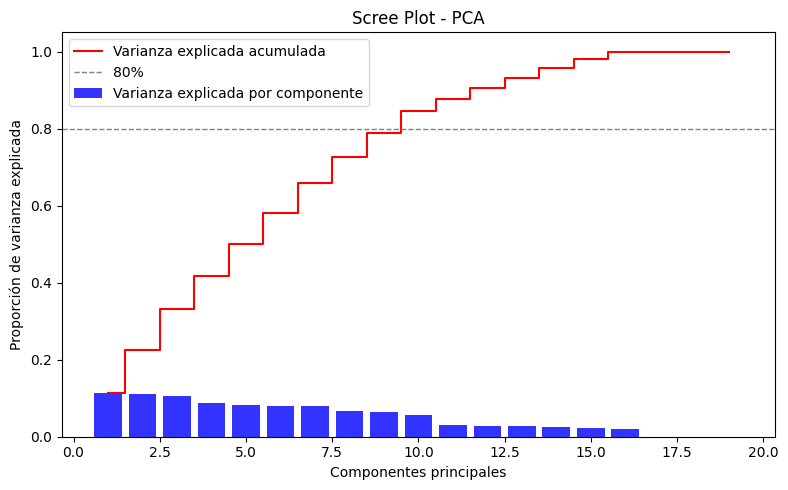

In [275]:
# Scree Plot
var_exp = pca.explained_variance_ratio_
n = len(var_exp)

x = np.arange(1, n+1)
cum = np.cumsum(var_exp)

plt.figure(figsize=(8,5))
plt.bar(x, var_exp, alpha=0.8, align='center', color='blue', label='Varianza explicada por componente')
plt.step(x, cum, where='mid', color='r', label='Varianza explicada acumulada')
plt.axhline(y=0.80, color='gray', linestyle='--', linewidth=1, label='80%')
plt.ylabel('Proporción de varianza explicada')
plt.xlabel('Componentes principales')
plt.title('Scree Plot - PCA')
plt.legend()
plt.tight_layout()
plt.show()

Elegimos las componentes principales según **criterio de varianza acumulada** (+80%)
- Las **Componentes Principales** seleccionadas son las primeras **10** que explican aproximadamente el **~84%** de la varianza total.

In [276]:
# Seleccionamos las columnas de características
features = X_std.columns.to_list()

# Obtenemos las clases únicas de la variable objetivo
unique_target = y.unique()
num_colors = len(unique_target)

# Definimos una paleta de colores con el mismo número de clases
color_palette = plt.get_cmap('tab20', num_colors)

# Creamos un diccionario que asigna cada clase a un color en formato HEX
target_color_map = {cultivo: mcolors.to_hex(color_palette(i)) for i,
                       cultivo in enumerate(unique_target)}

# Calculamos las cargas (loadings) de cada variable en los componentes principales
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Gráfico 2D de PCA con Plotly (primeras dos componentes principales)
fig = px.scatter(pca_df, x='pca0', y='pca1', color=pca_df["target"],
                 labels={'color': 'target'},
                 color_discrete_map=target_color_map,
                 title="Distribución de las variedades en 2 dimensiones")
fig.show()

# Gráfico 3D de PCA con Plotly (primeras tres componentes principales)
fig = px.scatter_3d(pca_df, x='pca0', y='pca1', z='pca2',
              color=pca_df["target"], labels={'color': 'target'},
              color_discrete_map=target_color_map,
              title="Distribución de las variedades en 3 dimensiones")
fig.show()

### Observaciones PCA:
- En los gráficos 2D y 3D de PCA, se observa que las diferentes variedades de cultivos no están claramente separadas, lo que indica que las características seleccionadas no permiten una diferenciación clara entre las clases.
- Esto sugiere que la tarea de clustering puede ser desafiante debido al solapamiento entre las variedades.
- No son lineales las relaciones entre las variables, lo que puede limitar la efectividad de PCA.

 ## 3. Isomap

In [277]:
def aplicar_isomap(X_std, y, n_vecinos=5, n_componentes=2):

    isomap = Isomap(n_neighbors=n_vecinos, n_components=n_componentes)
    X_reduced = isomap.fit_transform(X_std)

    columnas = [f"PC{i+1}" for i in range(n_componentes)]
    df_isomap = pd.DataFrame(X_reduced, columns=columnas)
    df_isomap['tipoCultivo'] = y.reset_index(drop=True)

    if n_componentes >= 2:
        fig = px.scatter(
            df_isomap,
            x='PC1', y='PC2',
            color=y,
            labels={'color':'Tipo de cultivo', 'PC1':'PC1', 'PC2':'PC2'},
            title=f'ISOMAP ({n_vecinos} vecinos, {n_componentes} componentes)'
        )
        fig.show()

    return df_isomap

In [278]:

for n_componentes in [2, 3]:
    for n_vecinos in [5, 25, 50]:
        aplicar_isomap(X_std, y, n_vecinos, n_componentes)
# aplicar_isomap(X_std, y, 10, 3)
# aplicar_isomap(X_std, y, 30, 3)
# aplicar_isomap(X_std, y, 5, 2)
# aplicar_isomap(X_std, y, 50, 2)

**Análisis Isomap:**
* Los grupos `tipoCultivo` no se separan claramente, 
sugiriendo un alto solapamiento en el espacio de características, 
incluso en una variedad no lineal.

## 4. t-SNE

In [279]:
# Función para aplicar t-SNE y graficar
def plot_tsne(X, y, max_iter=1000, n_components=2, perplexity=30, title='t-SNE'):
    tsne = TSNE(
        n_components=n_components, 
        perplexity=perplexity, 
        max_iter=max_iter, 
        random_state=42, 
        n_iter_without_progress=300, 
        verbose=1
    )
    X_tsne = tsne.fit_transform(X)

    tsne_df = pd.DataFrame(X_tsne, columns=['Component 1', 'Component 2'])
    tsne_df['tipoCultivo'] = y.reset_index(drop=True)

    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        data=tsne_df, 
        x='Component 1', 
        y='Component 2', 
        hue='tipoCultivo', 
        palette='Set1', 
        s=50,
        alpha=0.7,       
        edgecolor='white',     
        linewidth=0.5
    )
    plt.title(f'{title} (Iter: {max_iter}, Perp: {perplexity}, Comp: {n_components})')
    plt.xlabel('Componente 1')
    plt.ylabel('Componente 2')
    plt.legend(title='Tipo de Cultivo', frameon=True, shadow=True)
    plt.grid(alpha=0.3) 
    plt.tight_layout()
    plt.show()
    
    print(f"KL divergence final: {tsne.kl_divergence_:.4f}")  # 🔹 7. Métrica de calidad
    return X_tsne

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 163 samples in 0.001s...
[t-SNE] Computed neighbors for 163 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 163 / 163
[t-SNE] Mean sigma: 1.064511
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.767387
[t-SNE] KL divergence after 500 iterations: 1.142056


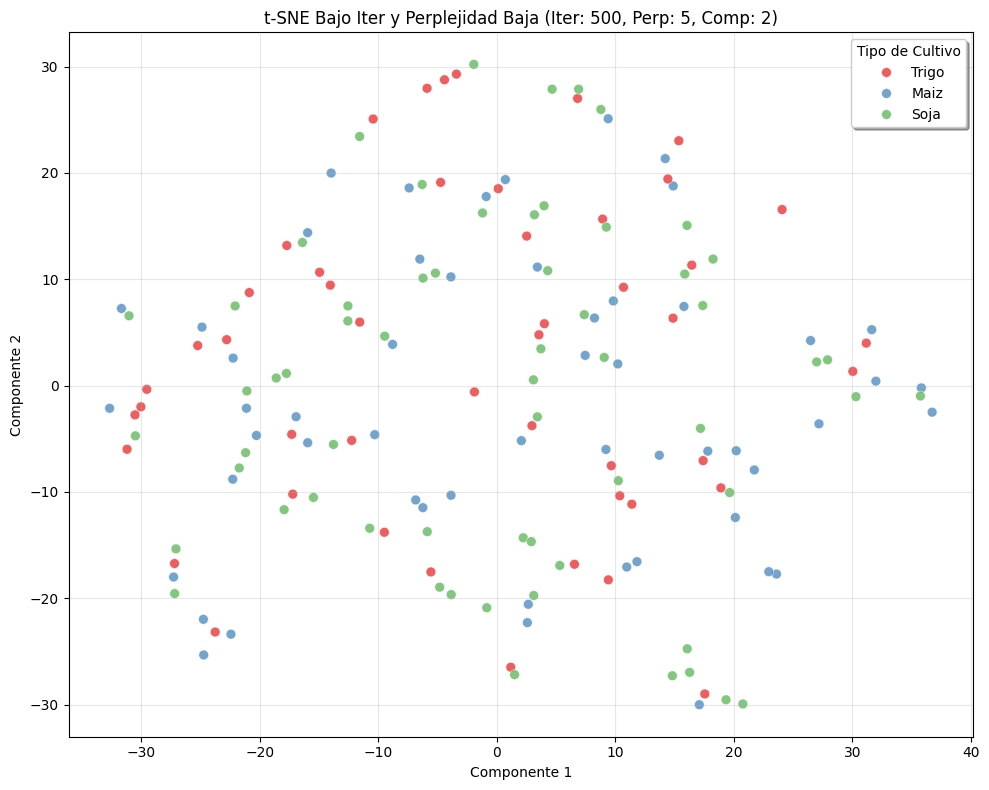

KL divergence final: 1.1421
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 163 samples in 0.000s...
[t-SNE] Computed neighbors for 163 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 163 / 163
[t-SNE] Mean sigma: 1.658126
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.104141
[t-SNE] KL divergence after 1350 iterations: 0.918800


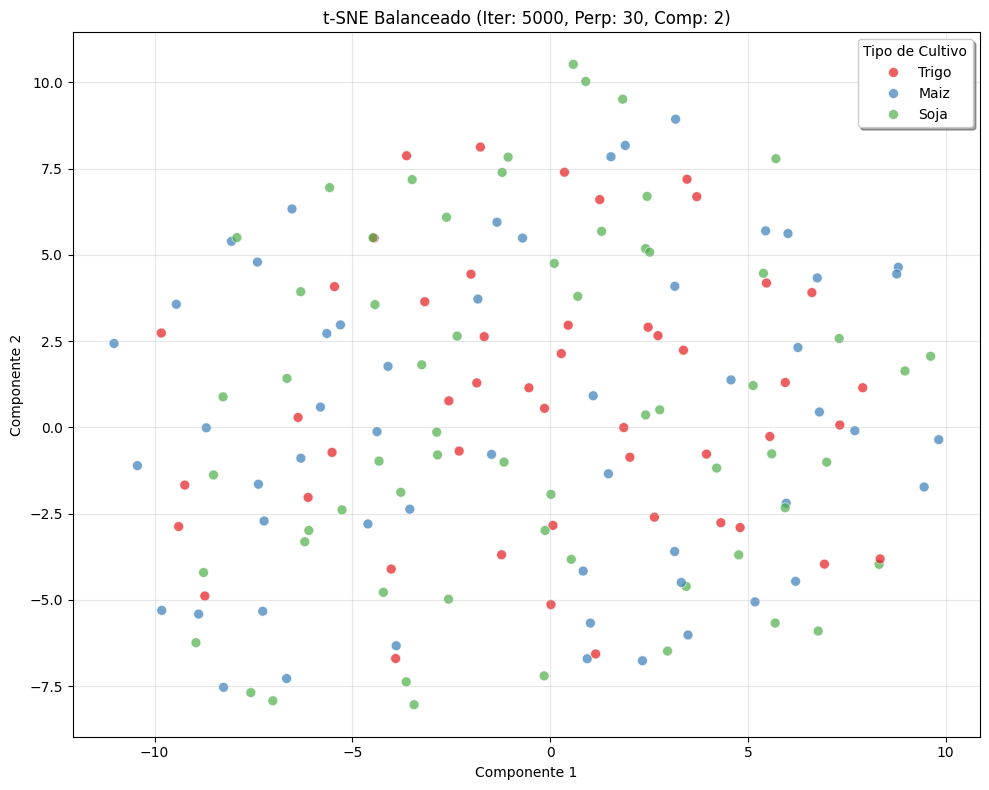

KL divergence final: 0.9188
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 163 samples in 0.000s...
[t-SNE] Computed neighbors for 163 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 163 / 163
[t-SNE] Mean sigma: 1.878064
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.231361
[t-SNE] KL divergence after 900 iterations: 0.723065


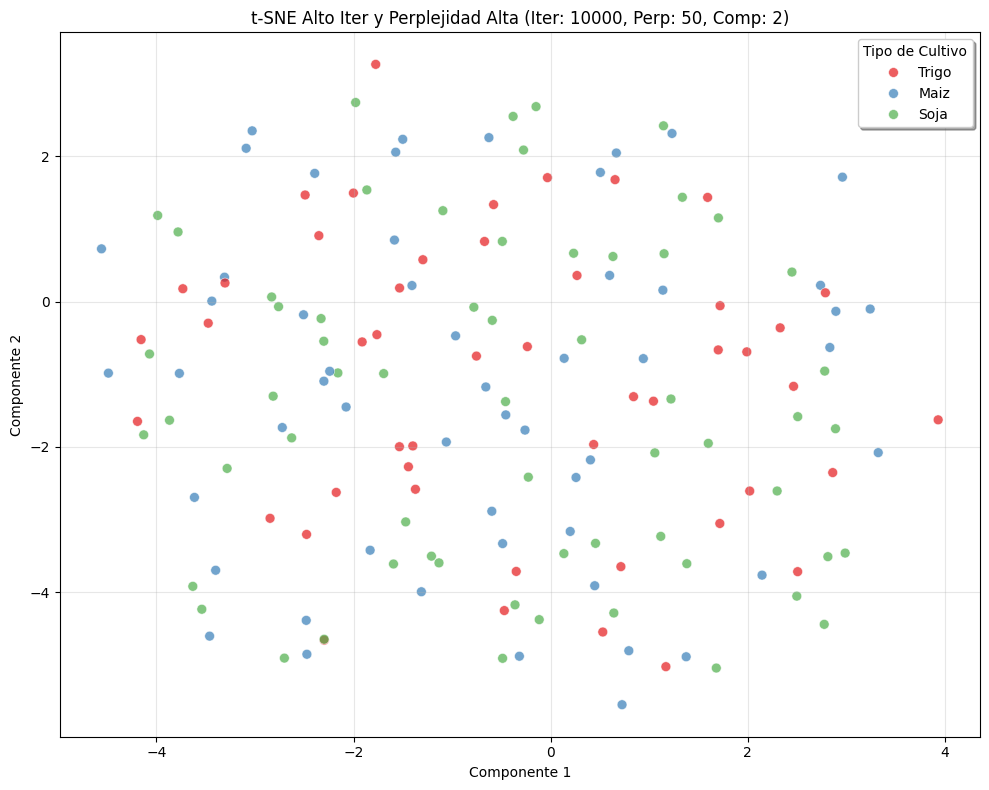

KL divergence final: 0.7231


array([[-0.5781011 ,  1.3337259 ],
       [ 0.4483116 , -3.9102557 ],
       [ 2.499383  , -4.053341  ],
       [-0.469306  , -4.2520733 ],
       [-0.22545548, -2.4164128 ],
       [-4.487789  , -0.9850465 ],
       [-3.3093042 ,  0.33513248],
       [ 3.2443466 , -0.10299246],
       [-1.693671  , -0.99136424],
       [ 1.7039139 ,  1.1502362 ],
       [-2.7016325 , -4.906007  ],
       [-2.479788  , -4.38674   ],
       [ 1.601164  , -1.9513865 ],
       [ 2.3000078 , -2.6067586 ],
       [-2.07517   , -1.4512559 ],
       [-0.7521689 , -0.7503696 ],
       [-1.1323627 , -3.5959144 ],
       [ 2.777801  , -4.441586  ],
       [ 0.84248996, -1.3089073 ],
       [ 0.13537616, -3.468242  ],
       [-0.31620878, -4.880409  ],
       [-3.8675618 , -1.6330875 ],
       [-1.4702644 , -3.032132  ],
       [ 0.3156149 , -0.5267116 ],
       [-0.48660672, -4.9090447 ],
       [ 1.7021648 , -0.6659406 ],
       [ 0.19959012, -3.1633356 ],
       [ 2.146716  , -3.7644875 ],
       [-1.3714279 ,

In [280]:
plot_tsne(X_std, y, max_iter=500, perplexity=5, title='t-SNE Bajo Iter y Perplejidad Baja')
plot_tsne(X_std, y, max_iter=5000, perplexity=30, title='t-SNE Balanceado')
plot_tsne(X_std, y, max_iter=10000, perplexity=50, title='t-SNE Alto Iter y Perplejidad Alta')

 ### **Análisis t-SNE:**
En todos los casos analizados, los puntos correspondientes a los distintos tipos de cultivo se superponen considerablemente, 
sin formar agrupaciones claramente diferenciadas.
Esto indica que t-SNE no logra separar las clases con las variables disponibles, 
lo cual puede ser esperable considerando que:

- t-SNE preserva principalmente relaciones locales (vecindarios cercanos), 
no necesariamente estructura global de clusters
- Los datos pueden no tener una estructura intrínsecamente separable en el espacio de características original
- La superposición sugiere que las variables actuales no capturan diferencias 
discriminativas suficientes entre tipos de cultivo

## 5. K-Means

### 5.1. Determinación de k (Codo y GAP)

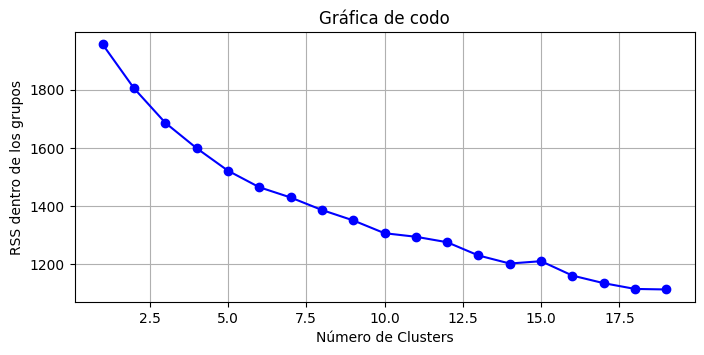

In [281]:
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=k, random_state=42).fit(X_std) for k in Nc]

# La suma de residuos cuadrados intra grupos de kMeans en sklearn se guarda en el atributo inertia
inertias = [model.inertia_ for model in kmeans]

plt.figure(figsize=(8, 3.5))
plt.plot(Nc,inertias, "bo-")
plt.xlabel('Número de Clusters')
plt.ylabel('RSS dentro de los grupos')
plt.title('Gráfica de codo')
plt.grid()
plt.show()

 ### Análisis Método del Codo en K-Means:

Observamos que en el gráfico del codo la inercia decrece de forma relativamente suave y continua, 
sin un "codo" pronunciado que indique un número óptimo claro de clusters.
Podríamos considerar k=10 como candidato, donde la curva sutilmente comienza a aplanarse, 
aunque la mejora continúa gradualmente hasta aproximadamente k=14.
Dado que nuestro problema tiene 3 tipos de cultivo, esperaríamos idealmente observar un codo marcado en 
k=3 si los cultivos fueran naturalmente separables y una caída abrupta de inercia al pasar de 2 a 3 clusters.
La ausencia de un codo pronunciado y la mejora continua con más clusters sugiere que:
- Los 3 tipos de cultivo no forman grupos compactos y bien diferenciados en el espacio de características
- Existe variabilidad significativa dentro de cada tipo de cultivo que K-means intenta capturar con subclusters
- Nuevamente, las variables actuales no discriminan efectivamente entre las clases reales

In [282]:
# Aplicamos el modelo con k=12
kmeans = KMeans(n_clusters=12, random_state=42,
                init='k-means++', n_init=5, algorithm='lloyd')
kmeans.fit(X_std) #Entrenamos el modelo
y_pred = kmeans.predict(X_std)

In [283]:
# A que cluster corresponde cada observacion
X_std['Etiquetas KMeans'] = kmeans.labels_
X_std['Etiquetas KMeans'] = X_std['Etiquetas KMeans'].astype('category')
X_std.head()

humedadSuelo(%)   pHSuelo  temperatura(°C)  precipitacion(mm)  humedad(%)  \
0         0.394017  1.040927         0.468253           1.084461    0.129232   
1         0.173440 -1.323141        -0.511037           1.501523    0.951804   
2         1.508827 -0.288861        -1.089796          -0.003546    0.676418   
3        -1.188775 -0.272444        -0.279151          -0.247304    0.672833   
4        -1.247397 -1.076884         0.378181           0.455088   -1.097812   

   horasLuzSolar  mlPesticida  diasTotales  rendimientoKg_hectarea  \
0       0.715899    -0.807933     1.414415               -1.060408   
1      -0.874106     1.589491     0.091070                0.961703   
2      -1.005182     1.750307    -0.081540                1.251525   
3       0.607619    -0.225437     1.471952               -1.488661   
4      -1.284430     0.414123    -0.196613                0.411652   

   indiceNDVI  tipoRiego_Aspersor  tipoRiego_Goteo  tipoRiego_Manual  \
0    1.132157               False             True             False   
1    0.569187                True            False             False   
2   -0.556753               False            False              True   
3   -0.275268               False             True             False   
4   -1.007130                True            False             False   

   tipoFertilizante_Inorganico  tipoFertilizante_Mixto  \
0                        False                    True   
1                        False                    True   
2                         True                   False   
3                        False                   False   
4                        False                    True   

   tipoFertilizante_Organico  estadoEnfermedadesCultivo_Leve  \
0                      False                            True   
1                      False                            True   
2                      False                            True   
3                       True                           False   
4                      False                           False   

   estadoEnfermedadesCultivo_Moderate  estadoEnfermedadesCultivo_Severo  \
0                               False                             False   
1                               False                             False   
2                               False                             False   
3                                True                             False   
4                                True                             False   

  Etiquetas KMeans  
0                0  
1               11  
2               10  
3                6  
4                9

In [284]:
fig = px.scatter_3d(X_std, x='humedadSuelo(%)', y='pHSuelo', z='temperatura(°C)',
                    color='Etiquetas KMeans',
                    title='Dispersión de las variedades de cultivo (K-means)')
fig.show()

In [285]:
fig = px.scatter_3d(X_std, x='humedadSuelo(%)', y='pHSuelo', z='temperatura(°C)',
                    color=y,
                    title='Dispersión de las variedades de cultivo (original)')
fig.show()

In [286]:
# Aplicamos el modelo, esta vez con k=8
kmeans = KMeans(n_clusters=8, random_state=42,
                init='k-means++', n_init=5, algorithm='lloyd')
kmeans.fit(X_std) #Entrenamos el modelo
y_pred = kmeans.predict(X_std)

In [287]:
# A que cluster corresponde cada observacion
X_std['Etiquetas KMeans'] = kmeans.labels_
X_std['Etiquetas KMeans'] = X_std['Etiquetas KMeans'].astype('category')
X_std.head()

humedadSuelo(%)   pHSuelo  temperatura(°C)  precipitacion(mm)  humedad(%)  \
0         0.394017  1.040927         0.468253           1.084461    0.129232   
1         0.173440 -1.323141        -0.511037           1.501523    0.951804   
2         1.508827 -0.288861        -1.089796          -0.003546    0.676418   
3        -1.188775 -0.272444        -0.279151          -0.247304    0.672833   
4        -1.247397 -1.076884         0.378181           0.455088   -1.097812   

   horasLuzSolar  mlPesticida  diasTotales  rendimientoKg_hectarea  \
0       0.715899    -0.807933     1.414415               -1.060408   
1      -0.874106     1.589491     0.091070                0.961703   
2      -1.005182     1.750307    -0.081540                1.251525   
3       0.607619    -0.225437     1.471952               -1.488661   
4      -1.284430     0.414123    -0.196613                0.411652   

   indiceNDVI  tipoRiego_Aspersor  tipoRiego_Goteo  tipoRiego_Manual  \
0    1.132157               False             True             False   
1    0.569187                True            False             False   
2   -0.556753               False            False              True   
3   -0.275268               False             True             False   
4   -1.007130                True            False             False   

   tipoFertilizante_Inorganico  tipoFertilizante_Mixto  \
0                        False                    True   
1                        False                    True   
2                         True                   False   
3                        False                   False   
4                        False                    True   

   tipoFertilizante_Organico  estadoEnfermedadesCultivo_Leve  \
0                      False                            True   
1                      False                            True   
2                      False                            True   
3                       True                           False   
4                      False                           False   

   estadoEnfermedadesCultivo_Moderate  estadoEnfermedadesCultivo_Severo  \
0                               False                             False   
1                               False                             False   
2                               False                             False   
3                                True                             False   
4                                True                             False   

  Etiquetas KMeans  
0                6  
1                3  
2                3  
3                1  
4                7

In [288]:
fig = px.scatter_3d(X_std, x='humedadSuelo(%)', y='pHSuelo', z='temperatura(°C)',
                    color='Etiquetas KMeans',
                    title='Dispersión de las variedades de cultivo (K-means)')
fig.show()

In [289]:
fig = px.scatter_3d(X_std, x='humedadSuelo(%)', y='pHSuelo', z='temperatura(°C)',
                    color=y,
                    title='Dispersión de las variedades de cultivo (original)')
fig.show()

Los scatterplots 3D muestran que no existe una separación clara entre los tipos de cultivo 
en el espacio de las variables originales. Los puntos se superponen considerablemente, 
sin formar agrupaciones visualmente distinguibles.

Número óptimo de clusters según GAP: 15


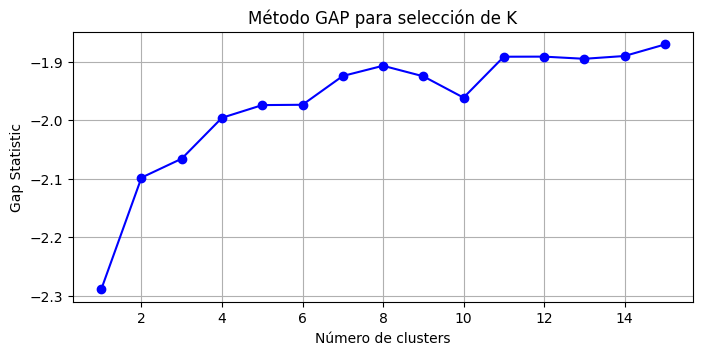

In [290]:
# --- Función para calcular la inercia ---
def calculate_intra_cluster_dispersion(X, k):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    return kmeans.inertia_

# --- Calcular Gap Statistic ---
gaps = []
max_k = 15

for k in range(1, max_k + 1):
    # Inercia real con los datos originales
    real_inertia = calculate_intra_cluster_dispersion(X_std, k)

    # Inercia con datos de referencia aleatorios
    inertia_list = []
    for _ in range(10):  # número de replicaciones
        random_data = np.random.rand(*X_std.shape)
        inertia_list.append(calculate_intra_cluster_dispersion(random_data, k))

    reference_inertia = np.mean(inertia_list)

    # Gap Statistic
    gap = np.log(reference_inertia) - np.log(real_inertia)
    gaps.append(gap)

# Número óptimo de clusters
optimal_k = np.argmax(gaps) + 1
print("Número óptimo de clusters según GAP:", optimal_k)

# --- Gráfico de Gap Statistic ---
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, max_k + 1), gaps, "bo-")
plt.xlabel("Número de clusters")
plt.ylabel("Gap Statistic")
plt.title("Método GAP para selección de K")
plt.grid()
plt.show()

# --- Aplicar KMeans con k óptimo ---
kmeans = KMeans(n_clusters=optimal_k, random_state=42, init='k-means++', n_init=5, algorithm='lloyd')
kmeans.fit(X_std)

X_std['Etiquetas KMeans'] = kmeans.labels_ #.astype('category')

# --- Gráfico 3D ---
fig = px.scatter_3d(
    X_std,
    x='humedadSuelo(%)',
    y='pHSuelo',
    z='temperatura(°C)',
    color='Etiquetas KMeans',
    title=f'Dispersión de las variedades de trigo (K-means con K={optimal_k})'
)
fig.show()

### Análisis del Método GAP Statistic
El gráfico del método GAP muestra que el valor máximo se alcanza en k=14 clusters, que sería el óptimo según este criterio estadístico. Sin embargo, observamos que:
1. A partir de k=6, se presenta una meseta donde GAP se mantiene relativamente alto y estable, sin más aumento significativo.
2. Este rango es consistente con el método del codo, en el que había aparecido k=14 como posibilidad.

Dado que k=14 parece excesivo para un dataset con solo 3 clases reales, y considerando que:
- GAP continúa aumentando ligeramente sin un máximo claro antes de k=14
- La mejora después de k=6 es pequeña
- Nuestro problema tiene 3 tipos de cultivo conocidos

Podríamos interpretar que ningún número de clusters captura adecuadamente la estructura real de los datos. Tanto el método del codo como GAP coinciden en que se necesitan muchos clusters (6-14) para modelar la variabilidad, lo cual refuerza que los 3 tipos de cultivo no forman grupos naturalmente compactos y separables con las variables actuales.

# 6. **Clustering jerárquico**

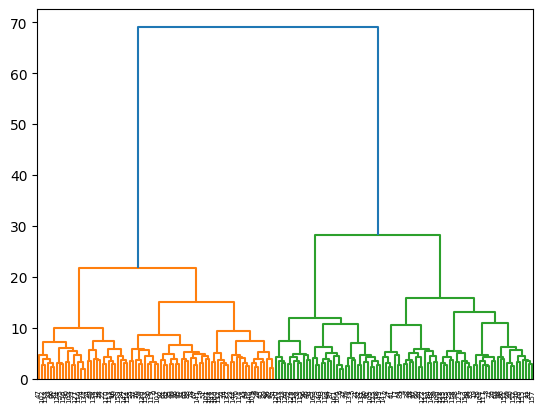

In [291]:
Z = linkage(X_std, "ward")

dendrogram(Z)
plt.show()

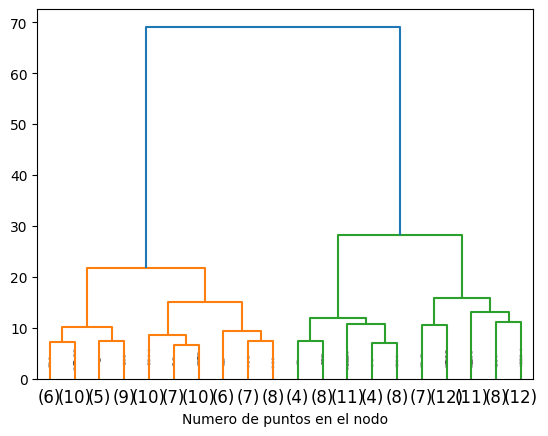

In [292]:
# Dibuja un dendrograma truncado (solo muestra las últimas p hojas)
dendrogram(Z,  truncate_mode = 'lastp', p = 20, show_leaf_counts = True,
           show_contracted = True)
plt.axhline(y=110, c='k', linestyle='dashed')
plt.xlabel("Numero de puntos en el nodo")
plt.show()

In [293]:
columnas_booleanas = X_std.select_dtypes(include=['bool']).columns

# Convertir esas columnas a tipo entero (True=1, False=0)
X_std[columnas_booleanas] = X_std[columnas_booleanas].astype(int)

# Verificar los cambios
print(X_std.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163 entries, 0 to 162
Data columns (total 20 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   humedadSuelo(%)                     163 non-null    float64
 1   pHSuelo                             163 non-null    float64
 2   temperatura(°C)                     163 non-null    float64
 3   precipitacion(mm)                   163 non-null    float64
 4   humedad(%)                          163 non-null    float64
 5   horasLuzSolar                       163 non-null    float64
 6   mlPesticida                         163 non-null    float64
 7   diasTotales                         163 non-null    float64
 8   rendimientoKg_hectarea              163 non-null    float64
 9   indiceNDVI                          163 non-null    float64
 10  tipoRiego_Aspersor                  163 non-null    int64  
 11  tipoRiego_Goteo                     163 non-n

In [294]:
distancias=[]
for i in range(1, 10):
    clustering = AgglomerativeClustering(n_clusters=i) # Aplica clustering jerárquico con i clusters
    clustering.fit(X_std)

    # Calcula la matriz de distancias por pares entre los puntos
    pairwise_distances = cdist(X_std, X_std, 'euclidean')

    # Calcula la distancia total dentro de los clusters
    distancia_total = 0
    for j in range(i):
        cluster_indices = np.where(clustering.labels_ == j)
        # Encuentra los índices de los puntos en el cluster j
        distancia_total += pairwise_distances[cluster_indices][:, cluster_indices].sum()
        # Suma las distancias dentro del cluster


    distancias.append(distancia_total)
    # Almacena la distancia total para el número de clusters i

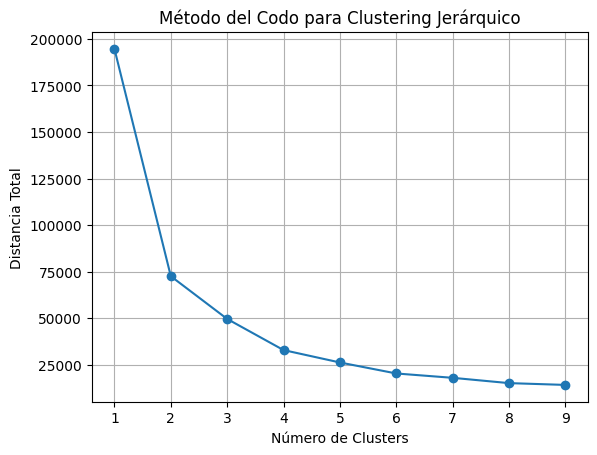

In [295]:
# Grafica la distancia total en función del número de clusters
plt.plot(range(1, 10), distancias, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Distancia Total')
plt.title('Método del Codo para Clustering Jerárquico')
plt.grid()
plt.show()

En el gráfico del codo para clustering jerárquico, observamos que el número óptimo de clusters se encuentra en k=2, ya que a partir de ese punto la curva comienza a aplanarse significativamente y la reducción de la distancia/inercia se vuelve marginal.
Tal vez también podría considerarse k=4, que tambien presente un sutil quiebre, menos pronunciado.

In [296]:
n_clusters = 3
clustering = AgglomerativeClustering(n_clusters=n_clusters)

cluster_assignments = clustering.fit_predict(X_std) # Asigna los clusters a los datos

X_std['Etiquetas jerarquico'] = cluster_assignments # Añade la columna con el cluster asignado a cada punto

X_std.head()

humedadSuelo(%)   pHSuelo  temperatura(°C)  precipitacion(mm)  humedad(%)  \
0         0.394017  1.040927         0.468253           1.084461    0.129232   
1         0.173440 -1.323141        -0.511037           1.501523    0.951804   
2         1.508827 -0.288861        -1.089796          -0.003546    0.676418   
3        -1.188775 -0.272444        -0.279151          -0.247304    0.672833   
4        -1.247397 -1.076884         0.378181           0.455088   -1.097812   

   horasLuzSolar  mlPesticida  diasTotales  rendimientoKg_hectarea  \
0       0.715899    -0.807933     1.414415               -1.060408   
1      -0.874106     1.589491     0.091070                0.961703   
2      -1.005182     1.750307    -0.081540                1.251525   
3       0.607619    -0.225437     1.471952               -1.488661   
4      -1.284430     0.414123    -0.196613                0.411652   

   indiceNDVI  ...  tipoRiego_Goteo  tipoRiego_Manual  \
0    1.132157  ...                1                 0   
1    0.569187  ...                0                 0   
2   -0.556753  ...                0                 1   
3   -0.275268  ...                1                 0   
4   -1.007130  ...                0                 0   

   tipoFertilizante_Inorganico  tipoFertilizante_Mixto  \
0                            0                       1   
1                            0                       1   
2                            1                       0   
3                            0                       0   
4                            0                       1   

   tipoFertilizante_Organico  estadoEnfermedadesCultivo_Leve  \
0                          0                               1   
1                          0                               1   
2                          0                               1   
3                          1                               0   
4                          0                               0   

   estadoEnfermedadesCultivo_Moderate  estadoEnfermedadesCultivo_Severo  \
0                                   0                                 0   
1                                   0                                 0   
2                                   0                                 0   
3                                   1                                 0   
4                                   1                                 0   

   Etiquetas KMeans  Etiquetas jerarquico  
0                 4                     0  
1                 7                     1  
2                 7                     1  
3                11                     1  
4                 8                     1  

[5 rows x 21 columns]

In [297]:
# Gráfico 3D del clustering jerárquico
fig = px.scatter_3d(
    X_std,
    x='humedadSuelo(%)',
    y='pHSuelo',
    z='temperatura(°C)',
    color='Etiquetas jerarquico',
    title=f'Clustering Jerárquico en 3D (n_clusters={n_clusters})',
    labels={'Etiquetas jerarquico': 'Cluster'},
    color_discrete_sequence=px.colors.qualitative.Pastel  # Paleta Pastel
)
fig.update_traces(marker=dict(size=5, opacity=0.7))
fig.show()

In [298]:
np.random.seed(42)
def calculate_intra_cluster_dispersion(X, k, linkage='ward'):
    clustering = AgglomerativeClustering(n_clusters=k, linkage=linkage)
    labels = clustering.fit_predict(X)

    # Convert X to a NumPy array for integer-based indexing
    X_np = X.to_numpy() if isinstance(X, pd.DataFrame) else X

    # Calcula los centroides de los clústeres como la media de los puntos dentro de cada clúster
    centroids = np.array([np.mean(X_np[labels == i], axis=0) for i in range(k)])

    # Calcula la dispersión intraclúster sumando las distancias al cuadrado entre los puntos y sus centroides
    # np.linalg.norm calcula la norma (distancia euclidiana) entre los puntos y el centroide correspondiente
    intra_cluster_dispersion = np.sum(np.linalg.norm(X_np[labels] - centroids[labels], axis=1)**2)
    return intra_cluster_dispersion

gaps = []
max_k = 15
for k in range(1, max_k + 1):
    # Calcula la dispersión intraclúster en los datos reales para 'k' clústeres
    X_std_numerical = X_std.select_dtypes(include=np.number)
    real_inertia = calculate_intra_cluster_dispersion(X_std, k, linkage='ward')

    inertia_list = []
    for _ in range(10):
      random_data = np.random.rand(*X_std.shape)
      intra_cluster_dispersion = calculate_intra_cluster_dispersion(random_data, k)
      inertia_list.append(intra_cluster_dispersion)

    reference_inertia = np.mean(inertia_list)

    gap = np.log(reference_inertia) - np.log(real_inertia)
    gaps.append(gap)

optimal_k = np.argmax(gaps) + 1

Número seleccionado de clusters según el Gap Statistic: 3


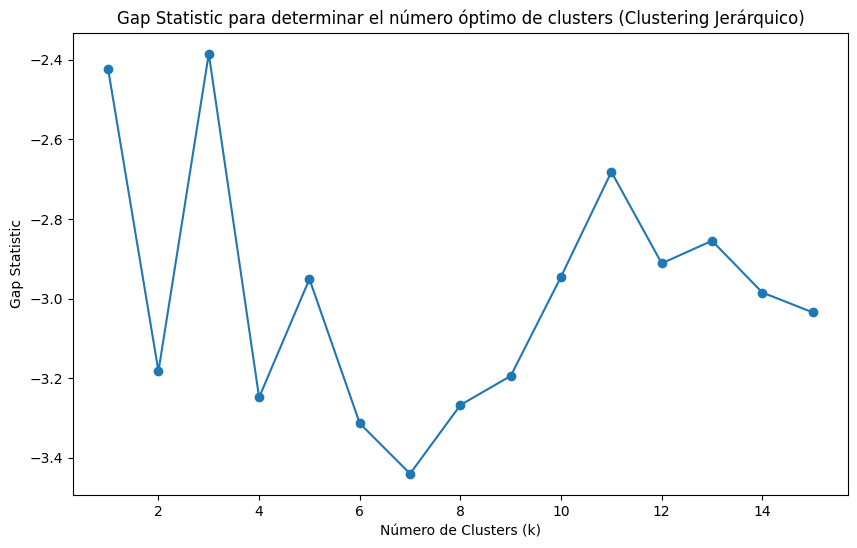

In [299]:
print("Número seleccionado de clusters según el Gap Statistic:", optimal_k)

plt.figure(figsize=(10, 6))
plt.plot(range(1, max_k + 1), gaps, marker='o')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Gap Statistic')
plt.title('Gap Statistic para determinar el número óptimo de clusters (Clustering Jerárquico)')
plt.show()

Al aplicar el método GAP al clustering jerárquico, observamos que el valor máximo de GAP se alcanza en k=3 clusters.
El pico en k=3 parece cercano a ~-2.4.
En general, los valores de la Gap Statistic muestran bruscas oscilaciones.

### Coeficiente de Silhouette

In [300]:
def calculate_silhouette(X_scaled, k, linkage='ward'):
    clustering = AgglomerativeClustering(n_clusters=k, linkage=linkage)
    labels = clustering.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, labels)
    sample_silhouette_values = silhouette_samples(X_scaled, labels)
    return silhouette_avg, sample_silhouette_values

max_k = 15

silhouette_scores = []
for k in range(2, max_k + 1):
    silhouette_avg, _ = calculate_silhouette(X_std, k)
    silhouette_scores.append(silhouette_avg)

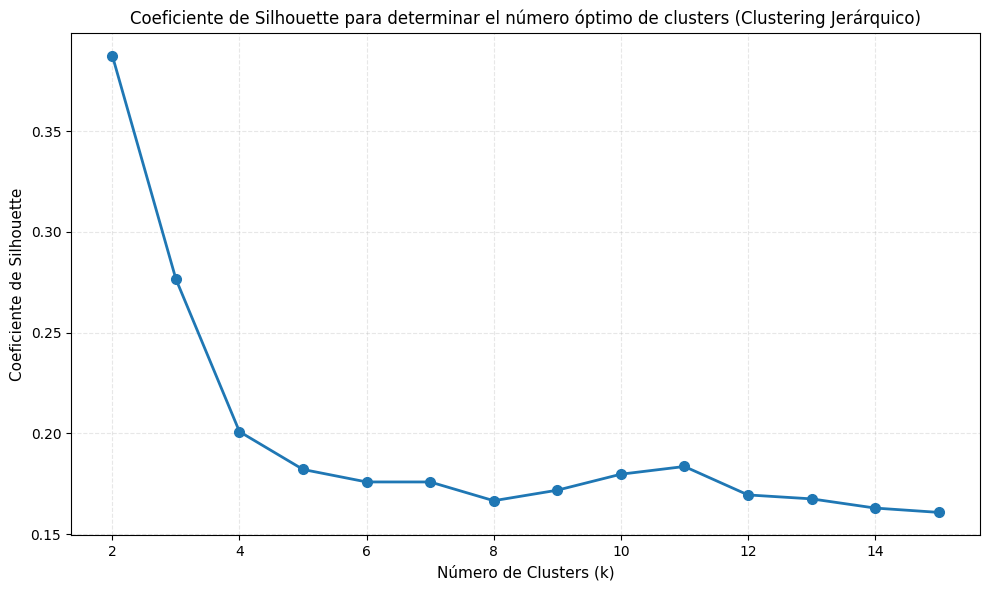

In [301]:
plt.figure(figsize=(10, 6))
plt.plot(range(2, max_k + 1), silhouette_scores, marker='o', linewidth=2, markersize=7)
plt.xlabel('Número de Clusters (k)', fontsize=11)
plt.ylabel('Coeficiente de Silhouette', fontsize=11)
plt.title('Coeficiente de Silhouette para determinar el número óptimo de clusters (Clustering Jerárquico)', fontsize=12)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

Después de k=2, el coeficiente cae bruscamente, 
lo que indica que agregar más clusters (k=3, k=4, etc.) empeora la calidad de la agrupación; 
los clusters se vuelven menos distinguibles entre sí.

Aunque k=2 es la mejor opción en este gráfico, 
un valor de ~0.38 no está muy cerca de 1. Esto sugiere que, si bien 2 es el número óptimo de grupos, 
la separación entre ellos es solo moderada, no excelente. Los clusters no son "indiferentes" (cercanos a 0), 
pero tampoco están "claramente distinguidos" (cercanos a 1).

# Conclusión

Tras aplicar los métodos de reducción de dimensionalidad (PCA, Isomap, t-SNE) y técnicas de clustering (k-means y clustering jerárquico) a un conjunto de datos con 163 muestras y 19 variables relacionadas con cultivos (como humedad del suelo, pH, temperatura, precipitación, entre otras), no se logró obtener visualizaciones que reflejaran una separación clara de los clústeres correspondientes a los tipos de cultivo (Trigo, Soja, Maíz). Este resultado puede atribuirse a varios factores fundamentales:

1. **Volumen limitado de datos**: El conjunto de datos, con solo 163 muestras (luego de la eliminación de faltantes), probablemente no proporciona suficiente información para que los algoritmos identifiquen patrones robustos que diferencien los cultivos. La alta dimensionalidad inicial (14 variables) agrava esta limitación, ya que los métodos de reducción y clustering requieren un mayor número de observaciones para capturar estructuras significativas.

2. **Ausencia de correlaciones relevantes**: El análisis de correlaciones mostró un valor máximo de -0.20 (ph del suelo con ml. de pesticidas), lo que indica que ninguna de las variables tiene una relación fuerte con la variable objetivo (`tipoCultivo`) ni entre sí. Esta falta de correlaciones relevantes sugiere que las variables incluidas en el conjunto de datos no son suficientemente discriminantes para distinguir entre los tipos de cultivo, lo que dificulta tanto la reducción de dimensionalidad como la formación de clústeres coherentes.

3. **Variables ruidosas o irrelevantes**: El preprocesamiento aplicado para codificar variables categóricas (como one-hot encoding) afectó la calidad de los datos y los resultados de los métodos aplicados. El dataset contaba con demasiadas dimensioens y además se sumaron las variables categóricas que fueron transformadas en dummies, que terminaron generando un total inicial de 17 dimensiones, de las cuales 9 tenían valores binarios.

4. **Métodos utilizados**: Los métodos de reducción de dimensionalidad empleados tienen supuestos que podrían no alinearse con la estructura de los datos. En PCA, por ejemplo, la baja correlación lineal (máximo -0.20) podría explicar la necesidad de generar muchas componentes principales para poder explicar un porcentaje suficiente de varianza. En cambio, ISOMAP y t-SNE, aunque diseñados para capturar estructuras no lineales, podrían no haber sido efectivos debido al pequeño tamaño del conjunto de datos, incluso habiendo intentado con distintas combinaciones de hiperparámetros. De manera similar, k-means y el clustering jerárquico podrían no ser ideales si los datos no presentan una estructura clara de agrupamiento.

5. **Solapamiento entre clases**: La falta de correlaciones relevantes y la incapacidad de los métodos para formar clusters significativos sugieren un alto grado de solapamiento entre las clases de cultivos en el espacio de características. Esto podría indicar que las variables medidas no capturan diferencias agronómicas o biológicas clave entre Trigo, Soja y Maíz, posiblemente debido a condiciones ambientales similares.